In [1]:
# MIT License
#
# @title Copyright (c) 2024 Mauricio Tec { display-mode: "form" }

# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.


# Welcome to the HDSI Winter Workshop on LLMs as Autonomous Agents


<img src="https://drive.google.com/uc?export=view&id=1q4SGPmn6sWQhskt4D-1D09q_6C9FDz_L" alt="drawing" width="400"/>


# **Part II: Grounding Agents with Fine-tuning and RL**

<a target="_blank" href="https://colab.research.google.com/github/mauriciogtec/hdsi-winter-workshop/blob/main/llm-agents-part2.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

Expected completion time: 1:30 hours


## March 7, 2025  <br> Mauricio Tec



**TL;DR** Our previous tutorial gave us the tools to understand agentic LLM workflows. In this tutorial we will talk about learning. We will use fine tuning and reinforcement learning to improve the LLM for specific tasks.

🔥🔥 📚 **Let's learn how to learn** 📚🔥🔥

*Familiarity with PyTorch models is assumed.*


<br>


<img src="https://drive.google.com/uc?export=view&id=1e3nRrx9IT5BjhWFwk1VKHS-a6m0EoMhc" alt="drawing" width="450"/>


See also:

* [Previous (Part I): Introduction to Agentic Frameworks](https://colab.research.google.com/github/mauriciogtec/hdsi-winter-workshop/blob/main/llm-agents-part1.ipynb)
* [Pre-assignment: Setup LLM Access & API Keys](https://colab.research.google.com/github/mauriciogtec/hdsi-winter-workshop/blob/main/pre-assignment.ipynb)


# Software Prerequisites & Setup


## Utility Function: Markdown Printing

As in part I, we will define a very simple utility function to print nicely in a colab notebook environment with Markdown. This is not really needed, but it will make some output visualizations easier and nicer.


In [2]:
from IPython.display import Markdown, display

def printmd(string):
    display(Markdown(string))

test = "`This is code`. *This is italics*. **This is bold**."
printmd(test)

`This is code`. *This is italics*. **This is bold**.

In [3]:
# @title Mount Google Colab
# @markdown While not needed, this will help us to save outputs and checkpoints
import os
from google.colab import drive
drive.mount('/content/drive')

# Create a target dir to save files
target_dir = '/content/drive/MyDrive/hdsi-winter-workshop/'
os.makedirs(target_dir, exist_ok=True)

Mounted at /content/drive


## Install Requirements

* The main tool will be `PyTorch`, which is the most common deep learning research framework.

<img src="https://upload.wikimedia.org/wikipedia/commons/9/96/Pytorch_logo.png" alt="drawing" width="300"/>


* Our second main tool, more specific to this tutorial, is the  `transformers` library, which provides access to various open-source `LLMs` as PyTorch. With transformers we have access to their internals, code, and weights.
* The `HuggingFace` tool ecosystem includes various other packages that we will need to be able to manipulate such massive models, which go beyond standard neural network training. Examples include `peft`, `bitsandbytes`, `accelerate`. For reinforcement learning and finetuning, we will use the `trl` library, which includes functionality for finetuning.
* Lastly, we will continue using the `smolagents` library for implementing the basic react loop functionality.

<img src="https://drive.google.com/uc?export=view&id=1RGuWtGHW88vk7T5JyMjnepG9YzwKJEVM" alt="drawing" width="600"/>


* 🎮 Let's play a game! While the techniques we will study apply to many environments. We will base our tutorial one nice text-based game called `TextWorld`.  

<img src="https://drive.google.com/uc?export=view&id=1fdfrUd4gxsute0b6qRdZ5d6l4y16D6UK" alt="drawing" width="600"/>


In [4]:
%pip install -q -U \
  transformers[torch,accelerate] \
  trl[peft] \
  bitsandbytes \
  textworld-express

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 26.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 74.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 37.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 118.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 94.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 40.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## 🤗 The HuggingFace Transformer Model 🤗

We will be working with the `meta-llama/Llama-3.2-1B-Instruct` model. Let us check access.

If your access is restricted, check out the [pre-assignment notebook](https://colab.research.google.com/github/mauriciogtec/hdsi-winter-workshop/blob/main/pre-assignment.ipynb) for more details on setting up access to Llama 3.2 on HuggingFace.


In [5]:
# Retrieve open AI key from Colab secrets
import os
from google.colab import userdata
os.environ["HF_TOKEN"] = userdata.get('HF_TOKEN')

In [6]:
# @title Test HF Model

import transformers
import peft
import torch

# Change logging of transformer to avoid so many warnings
import logging
logging.getLogger("transformers").setLevel(logging.ERROR)

model_id = "meta-llama/Llama-3.2-1B-Instruct"
# You can also try the 3B model, But you'll need a slightly larger GPU than the T4 entry-level Colab one

model = transformers.AutoModelForCausalLM.from_pretrained(
    model_id,
    # quantization_config=transformers.BitsAndBytesConfig(load_in_8bit=True),
    low_cpu_mem_usage=True,
    torch_dtype=torch.float16,
    device_map="auto",
    use_cache=True,
)

tokenizer = transformers.AutoTokenizer.from_pretrained(model_id)

# Some info about the model
num_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters in LLM: {num_params:,}")

# compute bytes in memory of model
obj_mem  = model.get_memory_footprint()
obj_mem_gb = obj_mem / (1024**3)
print(f"Memory footprint of model: {obj_mem_gb:.2f} gigabytes")


# Utility to generate text
def call_model(prompt, model, verbose=False, **kwargs):
    """Simple function to call the model."""
    # First empty cache
    torch.cuda.empty_cache()

    # Get model device
    device = next(model.parameters()).device

    # First convert to conversational form and use the chat tempalte
    messages= [{"role": "user", "content": prompt}]

    # Tokenize
    full_prompt = tokenizer.apply_chat_template(messages, add_generation_prompt=True, tokenize=False)
    inputs = tokenizer(full_prompt, return_tensors="pt").to(device)

    if verbose:
        print(f"== Prompt after applying chat template:\n{full_prompt}")
        print(f"== Tokenized promopt ==\n{inputs.input_ids}")

    # Generate
    with torch.no_grad():
      gen = model.generate(
          **inputs,
          max_new_tokens=100,
          eos_token_id=tokenizer.eos_token_id,
          **kwargs,
      )[0]

    # Remove generation tokens
    num_inputs = len(inputs["input_ids"][0])
    gen = gen[num_inputs:]

    if verbose:
        print(f"== Generated tokens ==\n{gen}")

    # Decode to text
    result = tokenizer.decode(gen, skip_special_tokens=True)

    if verbose:
        print(f"== Decoded text ==\n{result}")

    return result

call_model("What is the capital of France?", model, verbose=True);

config.json:   0%|          | 0.00/877 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/54.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

Number of parameters in LLM: 1,235,814,400
Memory footprint of model: 2.30 gigabytes
== Prompt after applying chat template:
<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 06 Mar 2025

<|eot_id|><|start_header_id|>user<|end_header_id|>

What is the capital of France?<|eot_id|><|start_header_id|>assistant<|end_header_id|>


== Tokenized promopt ==
tensor([[128000, 128000, 128006,   9125, 128007,    271,  38766,   1303,  33025,
           2696,     25,   6790,    220,   2366,     18,    198,  15724,   2696,
             25,    220,   2705,   2947,    220,   2366,     20,    271, 128009,
         128006,    882, 128007,    271,   3923,    374,    279,   6864,    315,
           9822,     30, 128009, 128006,  78191, 128007,    271]],
       device='cuda:0')
== Generated tokens ==
tensor([   791,   6864,    315,   9822,    374,  12366,     13, 128009],
       device='cuda:0')
== Decoded text ==
The capital of France is Paris.


## 🎮 The TextWorld Interactive Environment 🎮

Let's start the fun 🤩. We will play the`twc` (TextWorld common sense) games. There is the documentation's description of the game:

> `TextWorld Common Sense (twc)`

> Text game agents frequently learn the dynamics of environment --
such as the need to open a door before one can move through it --
from interacting with the environment itself, rather than using a pre-existing
knowledge base of common sense facts or object affordances that would speed
task learning. TextWorld Commonsense [Murugesan etal., 2021](https://arxiv.org/abs/2010.03790)
aims to evaluate agents on common sense knowledge that can not be directly learned from the
environment by providing agents a clean-up task where the agent must place
common household objects (e.g., a dirty dish) in their canonical locations
(e.g., the dishwasher) that can be found in knowledge bases such as ConceptNet.
Separate lists of objects are used in the training, development, and test sets,
meaning the agent can not learn object locations from the training set alone,
and must rely on an external common sense knowledge base to perform well on the
development and test sets. TextWorld Commonsense benchmark has three task
difficulty levels, with the easiest including a single location and object to
put away, while the hard setting includes up to p to 11 locations and any number
of task-relevant and distractor objects.

In [7]:
import random
from textworld_express import TextWorldExpressEnv


#  Textworld game Engine Creator
def env_factory(
    gameName: str = "twc",
    gameParams: str = "numLocations=3,includeDoors=1,numItemsToPutAway=4",
    time_limit: int = 12,
    gold_path: bool = False,
):
    env = TextWorldExpressEnv(envStepLimit=time_limit)
    env.load(gameName=gameName, gameParams=gameParams)
    return env

# Create new game instance
env = env_factory()
obs, infos = env.reset(seed=1234, gameFold="train")


# Take some random steps and collect experience in history
history = []
history.append("## Welcome to TextWorld")
history.append(f"`<Task>`: {env.getTaskDescription()}")
history.append(f"`<Starting Obs>`: {obs}")

for step_id in range(10):
    history.append(f"**Step {step_id + 1}**")

    # Select a random valid action
    randomAction = random.choice(infos['validActions'])

    # Take that action
    obs, reward, done, infos = env.step(randomAction)

    # Display action and the game's feedback.
    history.append(f"`<Valid Actions>` {infos['validActions']}")
    history.append(f"`<Action>` {randomAction}")
    history.append(f"`<Obs>` {obs}")
    history.append(f"`<Reward>` {reward:0.2f}")

history = "\n\n".join(history)
printmd(history)

## Welcome to TextWorld

`<Task>`: Your task is to pick up objects, then place them in their usual locations in the environment.

`<Starting Obs>`: You are in the pantry. In one part of the room you see a folding chair, that has nothing on it. There is also a shelf, that has nothing on it. You also see a clean plate. 
To the East you see a closed plain door. 

**Step 1**

`<Valid Actions>` ['move east', 'close door to east', 'open door to east', 'look around', 'inventory', 'take clean plate']

`<Action>` look around

`<Obs>` You are in the pantry. In one part of the room you see a folding chair, that has nothing on it. There is also a shelf, that has nothing on it. You also see a clean plate. 
To the East you see a closed plain door. 

`<Reward>` 0.00

**Step 2**

`<Valid Actions>` ['look around', 'close door to east', 'open door to east', 'inventory', 'move east', 'take clean plate']

`<Action>` look around

`<Obs>` You are in the pantry. In one part of the room you see a folding chair, that has nothing on it. There is also a shelf, that has nothing on it. You also see a clean plate. 
To the East you see a closed plain door. 

`<Reward>` 0.00

**Step 3**

`<Valid Actions>` ['inventory', 'open door to east', 'take clean plate', 'look around', 'close door to east', 'move east']

`<Action>` move east

`<Obs>` You can't move there, the door is closed. 

`<Reward>` 0.00

**Step 4**

`<Valid Actions>` ['take clean plate', 'close door to east', 'move east', 'look around', 'open door to east', 'inventory']

`<Action>` look around

`<Obs>` You are in the pantry. In one part of the room you see a folding chair, that has nothing on it. There is also a shelf, that has nothing on it. You also see a clean plate. 
To the East you see a closed plain door. 

`<Reward>` 0.00

**Step 5**

`<Valid Actions>` ['inventory', 'move east', 'take clean plate', 'look around', 'open door to east', 'close door to east']

`<Action>` move east

`<Obs>` You can't move there, the door is closed. 

`<Reward>` 0.00

**Step 6**

`<Valid Actions>` ['open door to east', 'inventory', 'move east', 'close door to east', 'look around', 'take clean plate']

`<Action>` look around

`<Obs>` You are in the pantry. In one part of the room you see a folding chair, that has nothing on it. There is also a shelf, that has nothing on it. You also see a clean plate. 
To the East you see a closed plain door. 

`<Reward>` 0.00

**Step 7**

`<Valid Actions>` ['open door to east', 'take clean plate', 'inventory', 'close door to east', 'look around', 'move east']

`<Action>` open door to east

`<Obs>` You open the plain door, revealing the kitchen. 

`<Reward>` 0.00

**Step 8**

`<Valid Actions>` ['close door to east', 'move east', 'put clean plate in folding chair', 'open door to east', 'put clean plate in shelf', 'inventory', 'look around']

`<Action>` take clean plate

`<Obs>` You take the clean plate.

`<Reward>` 0.12

**Step 9**

`<Valid Actions>` ['put clean plate in shelf', 'open door to east', 'inventory', 'look around', 'move east', 'close door to east', 'put clean plate in folding chair']

`<Action>` open door to east

`<Obs>` That is already open. 

`<Reward>` 0.00

**Step 10**

`<Valid Actions>` ['put clean plate in folding chair', 'close door to east', 'inventory', 'open door to east', 'move east', 'look around', 'put clean plate in shelf']

`<Action>` inventory

`<Obs>` Inventory: 
  a clean plate


`<Reward>` 0.00

# I. Benchmarking the Baseline Agents

Using what we learned in the previous part, let's evaluate how well the basic and chain of thought agents perform in TextWorld.


### Building Functionality: Creating the Planning and Action Steps

We will now implement some utility functions that will allow the agent to play the game.

#### *Coding Plan*

* 📜 **Build the task prompt** – Use `build_task_prompt(history, valid_actions)` to construct the task prompt, incorporating history and valid actions.
* 📝 **Generate a plan** – Use `planning_step(task_prompt, previous_plan=None)` to create an initial plan and revise it as new observations are made.
* 🤖 **Select the next action** – Use `action_step(task_prompt, valid_actions, example_thoughts=None)` to determine the next valid action, optionally incorporating a thought process.
* 🎯 **Ensure valid actions** – Use `extract_valid_action(response, valid_actions)` to validate and correct actions based on the valid action list.

In [8]:
def build_task_prompt(memory):
    """Builds the task prompt from memory, including examples."""
    return "\n\n".join(memory) + "Answer the questions below. Give all answers using plain text or bullet points. Don't use hastags `#`. Prefer short answers."


def planning_step(model, task_prompt, previous_plan=None):
    """Generates a plan."""
    plan_prompt = task_prompt + "### Question\nOutline a plan to solve the task.\n"

    return call_model(plan_prompt, model)


def action_step(model, task_prompt, valid_actions, thinking=False):
    """Generates an action. If example thoughts are provided, it first generates thoughts before selecting an action."""

    # Use chain of thought if needed
    if thinking:
        thought_prompt = task_prompt + (
            "\n\n###Question\nLet's think step by step before deciding the best next action.\n"
            f"The valid actions are: {','.join(valid_actions)}\n"
            "\n\n###Example:\nMy task is to move misplaced objects to their usual locations. I just arrived to the kitchen and my inventory has a kitchen knife. Then, I must drop the kitcken knife here.\n"
        )
        thoughts = call_model(thought_prompt, model)
        task_prompt += f"\n\n[Thoughts] {thoughts}"
    else:
        thoughts = ""

    # Obtain action, ensuring validity
    task_prompt += (
        "\n\nNow, choose exactly one valid action from the list and no additional information.\n"
         f"The valid actions are: {','.join(valid_actions)}\n"
         f"Example answer: {random.choice(valid_actions)}"
    )
    response = call_model(task_prompt, model).strip()
    for chars in ["[", "]", "`", '"', "'", "\n", ":"]:
        response = response.replace(chars, "")
    action = extract_valid_action(model, response, valid_actions)

    return action, thoughts


def extract_valid_action(model, response, valid_actions):
    """Ensures the extracted action is valid, querying the LLM if needed."""
    action = response.strip("[]`:").strip()
    if action in valid_actions:
        return action

    correction_prompt = (
        f"The agent responded: '{response}'. However, this is not a valid action.\n"
        f"The valid action list is {valid_actions}, extract the closest correct action.\n"
        "If the response contains unnecessary words like 'You move north to take the ball.', extract only 'move north'.\n"
        "If multiple optimal actions where suggested, choose the first valid action.\n"
        "Example corrections:\n"
        "- You open the cabinet.' → open shoe cabinet\n"
        "- 'Check my bag.' → inventory\n"
        "- Move in the east direction to take pick up shows and go west.' → move east\n"
        "- move south move north → move south\n"
        "- move north, pick up shoes → move north\n"
        "- pick up shoes, move north → pick up shoes\n"
        "Return only the corrected action from the valid action list without extra words.\n"
        "For instance, in the last example, your answer should simply be: pick up shoes"
    )
    corrected_action = call_model(correction_prompt, model).strip()
    return corrected_action

Let's now test these function in a single decision step.

In [9]:
# Initialize environment
env = env_factory()
obs, infos = env.reset(gameFold="train")

# Initialize memory
valid_actions = infos['validActions']
memory = [
    "## Welcome to TextWorld",
    f"`[Task]`: {env.getTaskDescription()}",
    f"`[Starting Obs]`: {obs}",
    f"`[Valid Actions]`: {valid_actions}",
]

# Initialize prompt
task_prompt = build_task_prompt(memory)

# # Start decision making
# plan = planning_step(model, task_prompt)
# memory.append(f"`[Initial Plan]` {plan}")

action, thoughts = action_step(model, task_prompt, valid_actions, thinking=True)

obs, reward, done, infos = env.step(action)

memory.append(f"`[Thoughts]` {thoughts}")
memory.append(f"`[Action]` {action}")
memory.append(f"`[Obs]` {obs}")
memory.append(f"`[Reward]` {reward:0.2f}")

printmd("\n\n".join(memory))

## Welcome to TextWorld

`[Task]`: Your task is to pick up objects, then place them in their usual locations in the environment.

`[Starting Obs]`: You are in the kitchen. In one part of the room you see a stove. There is also an oven. You also see a fridge that is closed. In another part of the room you see a counter, that has nothing on it. In one part of the room you see a kitchen cupboard that is closed. There is also a cutlery drawer that is closed. You also see a trash can that is closed. In another part of the room you see a dishwasher that is closed. In one part of the room you see a dining chair, that has nothing on it. There is also a copybook. 
To the South you see a closed frosted-glass door. To the West you see the living room. 

`[Valid Actions]`: ['open door to south', 'open dishwasher', 'move west', 'open cutlery drawer', 'inventory', 'open kitchen cupboard', 'take copybook', 'close door to south', 'move south', 'open trash can', 'open fridge', 'look around']

`[Thoughts]` To start, I will look around the kitchen to see where the misplaced objects are. I see the stove, oven, fridge, counter, kitchen cupboard, cutlery drawer, trash can, and dishwasher.

`[Action]` open door to south

`[Obs]` You open the frosted-glass door, revealing the pantry. 

`[Reward]` 0.00

### Playing a Full Episode

Let's put together our functions we created above into a "rollout" loop to play a full episode.

*Coding Plan*

* 👾 The game engine must be initiated
* 📖 We ask the agent for an initial plan, and revise it so often.
* 📈 We need to keep adding observations and actions to the memory
* 💸 We need to track the total reward of the agent
* 📀 At each step, we ask the agent for the action to take using the functions we just created in the previous step.


In [10]:
from datetime import datetime # to include time in loop
from typing import Literal  # hint valid arguments to a function
from tqdm.auto import tqdm  # progress bar


def episode_rollout(
    model: transformers.PreTrainedModel,
    gameFold: str = Literal["train", "valditation", "test"],
    thinking: bool = False,
    planning: bool = False,
    planning_interval: int = 3,
    env_factory_options: dict = {},
):
    # Set model in eval mode, no dropout, etc..)
    model.eval()

    # Initialize env
    env = env_factory(**env_factory_options)
    obs, infos = env.reset(gameFold=gameFold)

    # Initialize Memory
    memory = []
    memory.append(f"`[Task]`: {env.getTaskDescription()}")
    memory.append(f"`[Starting Obs]`: {obs}")


    # Make task prompt
    task_prompt = build_task_prompt(memory)

    # Make initial plan
    if planning:
        plan = planning_step(model, task_prompt)
        memory.append(f"`[Initial Plan]`: {plan}")

    # Start loop
    done = False
    total_reward = 0.0
    pbar = tqdm(desc="Episode Progress") # progress bar
    collected_data = []  # useful for training later

    step = 0
    while not done:
        step += 1

        # Update task prompt
        memory.append(f"###  `Action step {step}`")
        memory.append(f"`[Time]` {datetime.now().strftime('%H:%M:%S')}")
        memory.append(f"`[Valid Actions]`: {infos['validActions']}")
        task_prompt = build_task_prompt(memory)

        # Get new action from LLM
        # Update task prompt before action
        action, thoughts = action_step(
            model,
            task_prompt,
            infos['validActions'],
            thinking,
        )

        # Advance the Environment
        obs, reward, done, infos = env.step(action)

        # Update memory
        if thinking:
            memory.append(f"`[Thoughts]`:\n\n{thoughts}")
        memory.append(f"`[Action]`: {action}")
        memory.append(f"`[Reward]`: {reward:0.2f}")
        memory.append(f"`[Obs]`: {obs}")

        if planning and step % planning_interval == 0:
            plan = planning_step(model, task_prompt, plan)
            memory.append(f"`[Updated Plan]`: {plan}")

        # Append experience to data
        collected_data.append((task_prompt, thoughts, action, obs, reward))

        total_reward += reward
        pbar.update(1)

    return memory, collected_data, total_reward


memory, _, _ = episode_rollout(
    model, gameFold="test", thinking=True, env_factory_options=dict(time_limit=5),
)

printmd('\n\n'.join(memory))

Episode Progress: 0it [00:00, ?it/s]

`[Task]`: Your task is to pick up objects, then place them in their usual locations in the environment.

`[Starting Obs]`: You are in the corridor. In one part of the room you see a key holder, that has nothing on it. There is also a shoe cabinet that is closed. You also see a umbrella stand, that has nothing on it. In another part of the room you see a hat rack, that has nothing on it. In one part of the room you see a coat hanger, that has nothing on it. There is also a brown cap. 
To the South you see the living room. To the West you see a closed wood door. 

###  `Action step 1`

`[Time]` 19:50:57

`[Valid Actions]`: ['look around', 'take brown cap', 'move west', 'open door to west', 'open shoe cabinet', 'inventory', 'move south', 'close door to west']

`[Thoughts]`:

to move west 
to the living room

`[Action]`: move west

`[Reward]`: 0.00

`[Obs]`: You can't move there, the door is closed. 

###  `Action step 2`

`[Time]` 19:50:57

`[Valid Actions]`: ['take brown cap', 'move west', 'open door to west', 'inventory', 'close door to west', 'move south', 'open shoe cabinet', 'look around']

`[Thoughts]`:

You move west.
 
You can't move there, the door is closed.

`[Action]`: move west

`[Reward]`: 0.00

`[Obs]`: You can't move there, the door is closed. 

###  `Action step 3`

`[Time]` 19:50:57

`[Valid Actions]`: ['inventory', 'close door to west', 'move south', 'move west', 'open shoe cabinet', 'open door to west', 'look around', 'take brown cap']

`[Thoughts]`:

To move the misplaced objects to their usual locations, we need to follow the steps in the correct order.

### Step 1: Move the shoe cabinet to its usual location
The shoe cabinet is in the living room. To move it, we need to open the door to the living room.

### Step 2: Close the door to the living room
We have already done this.

### Step 3: Move the shoe cabinet to its usual location
We can now move the shoe cabinet to

`[Action]`: close door to west

`[Reward]`: 0.00

`[Obs]`: That is already closed. 

###  `Action step 4`

`[Time]` 19:51:00

`[Valid Actions]`: ['inventory', 'open shoe cabinet', 'look around', 'open door to west', 'take brown cap', 'close door to west', 'move west', 'move south']

`[Thoughts]`:

To move the misplaced objects to their usual locations, we need to follow the steps in the correct order.

### Step 1: Move the shoe cabinet to its usual location
The shoe cabinet is in the living room. To move it, we need to open the door to the living room.

### Step 2: Close the door to the living room
We have already done this.

### Step 3: Move the shoe cabinet to its usual location
We can now move the shoe cabinet to

`[Action]`: open door to west

`[Reward]`: 0.00

`[Obs]`: You open the wood door, revealing the laundry room. 

###  `Action step 5`

`[Time]` 19:51:02

`[Valid Actions]`: ['move west', 'inventory', 'move south', 'take brown cap', 'look around', 'close door to west', 'open shoe cabinet', 'open door to west']

`[Thoughts]`:

To move the misplaced objects to their usual locations, we need to follow the steps in the correct order.

### Step 1: Move the shoe cabinet to its usual location
The shoe cabinet is in the living room. To move it, we need to open the door to the living room.

### Step 2: Close the door to the living room
We have already done this.

### Step 3: Move the shoe cabinet to its usual location
We can now move the shoe cabinet to

`[Action]`: look around

`[Reward]`: 0.00

`[Obs]`: You are in the corridor. In one part of the room you see a key holder, that has nothing on it. There is also a shoe cabinet that is closed. You also see a umbrella stand, that has nothing on it. In another part of the room you see a hat rack, that has nothing on it. In one part of the room you see a coat hanger, that has nothing on it. There is also a brown cap. 
To the South you see the living room. Through an open wood door, to the West you see the laundry room. 

###  `Action step 6`

`[Time]` 19:51:04

`[Valid Actions]`: ['look around', 'inventory', 'take brown cap', 'open door to west', 'open shoe cabinet', 'close door to west', 'move west', 'move south']

`[Thoughts]`:

To move the misplaced objects to their usual locations, we need to follow the steps in the correct order.

### Step 1: Move the shoe cabinet to its usual location
The shoe cabinet is in the living room. To move it, we need to open the door to the living room.

### Step 2: Close the door to the living room
We have already done this.

### Step 3: Move the shoe cabinet to its usual location
We can now move the shoe cabinet to

`[Action]`: inventory

`[Reward]`: 0.00

`[Obs]`: Inventory: 
  Your inventory is currently empty.


### Benchmark over several episodes

Now the moment of truth 😱. Let's run several episodes and collect the experience.
For the interest of time. We will pre-save these results and load them.
But feel free to re-run.

In [11]:
import json
import requests

## Uncomment to rerun everything, by default, result is pre-saved

# episodes = {"vanilla": [], "thinking": []}

# num_episodes_per_agent = 20

# for agent, results in episodes.items():
#     printmd(f"### Agent {agent}")
#     thinking = (agent == "thinking")

#     for ep in range(num_episodes_per_agent):
#         printmd(f"#### Episode {ep}")
#         memory, data, total_reward = episode_rollout(model, gameFold="test", thinking=thinking)
#         results.append({"ep": ep, "total_reward": total_reward, "memory": memory, "data": data})

# with open(f"{target_dir}/episodes_baseline_agents.json", "w") as f:
#     json.dump(episodes, f)

# Download pre-saved results_baseline_agents.json generated in the previous cell from Github
# Comment following lines if re-running data collection

url = "https://raw.githubusercontent.com/mauriciogtec/hdsi-winter-workshop/refs/heads/main/episodes_baseline_agents.json"
baseline_episodes = json.loads(requests.get(url).text)

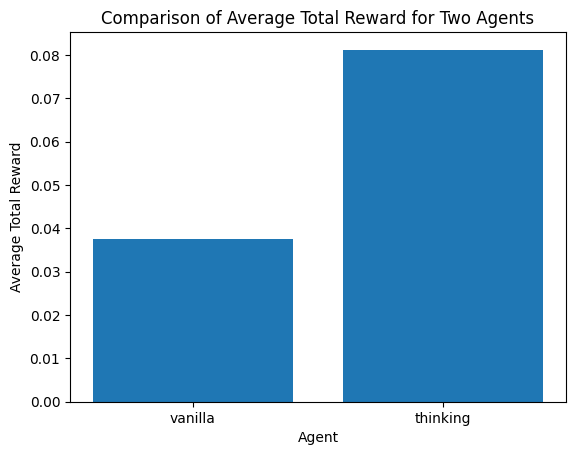

In [12]:
import numpy as np
import matplotlib.pyplot as plt

avg_rewards = {
    a: np.mean([ep["total_reward"] for ep in eps])
    for a, eps in baseline_episodes.items()
}

# make a bar chart
agents = list(avg_rewards.keys())
rewards = list(avg_rewards.values())

plt.bar(agents, rewards)
plt.xlabel("Agent")
plt.ylabel("Average Total Reward")
plt.title("Comparison of Average Total Reward for Two Agents")
plt.show()

# II. Supervised Fine-tuning (SFT) with Low-rank Adaptation (LORA)

In many problems, it is possible to collect demonstration data and learned an optimal strategy with supervision. For example, this could mean a human playing the game. In our case, text world comes with an engine to generate "gold paths" which help solve the task.

**Learning Plan**

* 📚 We will setup the LLM for efficient training using parameter efficient fine-tuning with LORA [(Hu et al., 2021)](https://arxiv.org/abs/2106.09685).
* 🥇 We will use the gold path engine to create a demonstration dataset
* 🏋️‍♀️ We will use the demonstration dataset for SFT
* 📈 We will evaluate the improved LLM

### 2.1 A primer on SFT and LORA

🕸️ LLMs are just neural networks. In particular, LLMs use the `transformer` architecture introduced in the paper *Attention Is All You Need*  [(Vaswani et al., 2017)](https://arxiv.org/abs/1706.03762). There is a good reason why this paper has over 100k citations ❗️


<figure>
<img src="https://drive.google.com/uc?export=view&id=1isVB0kvxCiE4Mz6eWaDaUu1QDI5BvZNC" alt="drawing" width="600"/>
<figcaption>
<b>Fig.</b> Schemetic representation of the Transformer Architecture and next-token prediction task.<br><em>Original image and blogpost</em>: <a href='https://medium.com/@akash.kesrwani99/understanding-next-token-prediction-concept-to-code-1st-part-7054dabda347'>Understanding Next Token Prediction: Concept To Code: 1st part!</a>
</figcaption>
</figure>


* 🔧 **Fine-tuning** 🔧
  * Fine tuning means updating the weights (parameters) of the neural network using a smaller dataset (aka downstream task).
  * In the context of LLM agents, we may also call this step *grounding* to the task.
  * Finetuning is typically done for far fewer optimization steps than the original training, and usually with smaller learning rates.
  * Finetuning is almost always better than training a model from scratch on the new ata.

* 🎻 **Classic approach** 🎻
  * *Last-layer tuning*: Retraining only the last layer of neural network.
  * *Full finetuning*: Update all weights of the network.
In regular neural network, it is common to update *all* the weights of neural network during finetuning.

#### 🦜 **LORA** 🦜
  * LORA takes the best of both finetuning regimes. Few parameters to train, but performs much better than last-layer tuning because it improves the entire neural network.
  * LORA or its many variations have become the standard to finetune LLMs [(Mao et al., 2024)](https://arxiv.org/abs/2407.11046)
  * The main idea is train an *low-rank adapter* as follows, which, for every parameter of the neural network, adds a new weight with fewer free parameters using the magic of low-rank matrix product factorization. The idea is illustrated below.
* 😱 **Worry not!** 😱
  * LORA is easily used without understanding its detailed inner workings.


<figure>
<img src="https://drive.google.com/uc?export=view&id=1HHeFZPdrVQWvA1EbWTHtyAuw_YNJjc-B" alt="drawing" width="800"/>
<figcaption>
<b>Fig.</b> Illustration of LORA.<br><em>Original image</em>: <a href='https://huggingface.co/docs/peft/main/en/developer_guides/lora'>HuggingFace PEFT docs</a>
</figcaption>
</figure>

#### 🏋🏽‍♂️ SFT is still next-token prediction** 🏋🏽‍♂️


In LLMs, the next-token prediction is trained using the **Cross-entropy Loss**, which measures how well the model's predicted probability distribution aligns with the true next token. SFT still uses this loss.

$$
\mathcal{L} = - \frac{1}{N} \sum_{i=1}^{N} \log \hat{P}_{\theta}(x_i | x_{<i})
$$

where:
- $N$ is the number of tokens in the sequence,
- $\hat{P}_{\theta}(x_i | x_{<i})$ represents the **predicted probability** of the correct token $x_i$ given the previous tokens,
- $x_{<i}$ represents the **context** (all previous tokens up to position $i$).

Since modern LLMs output **logits** (unnormalized scores for each token in the vocabulary), the probability $\hat{P}_{\theta}(x_i | x_{<i})$ is obtained by applying a **softmax**:

$$
\hat{P}_{\theta}(x_i | x_{<i}) = \frac{\exp(\text{logit}_{i, x_i})}{\sum_{j=1}^{V} \exp(\text{logit}_{i, j})}
$$

where:
- $\text{logit}_{i, x_i}$ is the model's predicted score for the correct next token $x_i$ at position $i$,
- $V$ is the vocabulary size,
- The denominator sums over all token scores to normalize them.


🐍 Cross-entropy in Pytorch 🐍

The cross-entropy is computed using `torch.nn.functional.cross_entropy`, which **directly takes raw logits** (not softmaxed) and target indices:

```python
# Example logits from a model (batch_size=1, seq_len=5, vocab_size=10)
logits = torch.tensor([
    [  # Sequence of 5 tokens (seq_len=5), each with vocab_size=10 logits
        [2.0, 1.0, 0.1, 3.2, 0.5, 2.3, 1.1, 0.2, 0.4, 1.7],  # Token 1
        [1.1, 2.5, 0.3, 2.8, 1.6, 1.7, 0.5, 0.7, 0.9, 1.3],  # Token 2
        [0.9, 1.4, 3.1, 1.5, 1.3, 0.8, 2.1, 1.9, 2.4, 0.7],  # Token 3
        [2.2, 0.5, 1.7, 1.8, 0.3, 2.6, 1.2, 1.5, 1.9, 0.6],  # Token 4
        [1.7, 2.2, 1.0, 1.4, 2.3, 0.9, 1.5, 1.6, 2.1, 1.8]   # Token 5
    ]
])  # Shape: (batch_size=1, seq_len=5, vocab_size=10)

# Target tokens (ground truth indices), same shape as seq_len
targets = torch.tensor([[3, 1, 2, 5, 4]])  # Shape: (batch_size=1, seq_len)

# Compute cross-entropy loss directly
loss = torch.nn.functional.cross_entropy(logits, targets)
```

### 2.2 Gather the Demonstration dataset

The strategy will be to mimic our previous episode_rollout busing the `env.getGoldActionSequence()` feature and execute that path.

In [14]:
def expert_episode_rollout(
    gameFold: str = Literal["train", "valditation", "test"],
    env_factory_options: dict = {},
):
    # Initialize env
    env = env_factory(**env_factory_options)
    obs, infos = env.reset(gameFold=gameFold, generateGoldPath=True)
    gold_actions = env.getGoldActionSequence()

    # Initialize Memory
    memory = []
    memory.append("## Welcome to TextWorld")
    memory.append(f"`[Task]`: {env.getTaskDescription()}")
    memory.append(f"`[Starting Obs]`: {obs}")

    # Make initial plan
    # Print progress
    pbar = tqdm(desc="Episode Progress")

    # Collected prompt/action/reward triples for training
    collected_data = []

    # Start loop
    done = False
    total_reward = 0.0

    step = 0
    while not done:
        # Update task prompt
        memory.append(f"***`Action step {step}`**")
        memory.append(f"`[Time]` {datetime.now().strftime('%H:%M:%S')}")
        memory.append(f"`[Valid Actions]`: {infos['validActions']}")
        task_prompt = build_task_prompt(memory)

        # Execute gold path action
        action = gold_actions[step]

        # Advance the Environment
        obs, reward, done, infos = env.step(action)

        # Update memory
        memory.append(f"`[Action]`: {action}")
        memory.append(f"`[Reward]`: {reward:0.2f}")
        memory.append(f"`[Obs]`: {obs}")

        collected_data.append((task_prompt, "", action, reward))  # empty for the thoughts

        total_reward += reward
        step += 1
        pbar.update(1)

    return memory, collected_data, total_reward

In [32]:
expert_episodes = {'expert': []}

num_episodes_per_agent = 20

for ep in range(num_episodes_per_agent):
    memory, data, total_reward = expert_episode_rollout(gameFold="train")
    expert_episodes['expert'].append({"ep": ep, "total_reward": total_reward, "memory": memory, "data": data})

mean_reward_expert = np.mean([ep["total_reward"] for ep in expert_episodes["expert"]])
print(f"Mean reward for expert: {mean_reward_expert}")

# Visualize expert episode
printmd('\n\n'.join(expert_episodes['expert'][0]['memory']))

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/py4j/java_gateway.py", line 1224, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/py4j/java_gateway.py", line 1228, in send_command
    raise Py4JNetworkError(
py4j.protocol.Py4JNetworkError: Error while receiving
ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:33153)
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/py4j/java_gateway.py", line 982, i

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Mean reward for expert: 0.75625


## Welcome to TextWorld

`[Task]`: Your task is to pick up objects, then place them in their usual locations in the environment.

`[Starting Obs]`: You are in the bathroom. In one part of the room you see a dressing table, that has nothing on it. There is also a sink, that has nothing on it. You also see a wall hook, that has nothing on it. In another part of the room you see a bath mat. In one part of the room you see a toilet roll holder, that has nothing on it. There is also a towel rack, that has nothing on it. You also see a bath tub, that has nothing on it. In another part of the room you see a shower, that has nothing on it. In one part of the room you see a trash can that is closed. There is also a bathroom cabinet that is closed. You also see a toilet. In another part of the room you see a clean black bra. In one part of the room you see a dirty brown blazer. 
To the North you see a closed wood door. To the West you see the bedroom. 

***`Action step 0`**

`[Time]` 20:18:15

`[Valid Actions]`: ['open door to north', 'take clean black bra', 'take dirty brown blazer', 'open trash can', 'move west', 'close door to north', 'move north', 'inventory', 'open bathroom cabinet', 'look around']

`[Action]`: look around

`[Reward]`: 0.00

`[Obs]`: You are in the bathroom. In one part of the room you see a dressing table, that has nothing on it. There is also a sink, that has nothing on it. You also see a wall hook, that has nothing on it. In another part of the room you see a bath mat. In one part of the room you see a toilet roll holder, that has nothing on it. There is also a towel rack, that has nothing on it. You also see a bath tub, that has nothing on it. In another part of the room you see a shower, that has nothing on it. In one part of the room you see a trash can that is closed. There is also a bathroom cabinet that is closed. You also see a toilet. In another part of the room you see a clean black bra. In one part of the room you see a dirty brown blazer. 
To the North you see a closed wood door. To the West you see the bedroom. 

***`Action step 1`**

`[Time]` 20:18:15

`[Valid Actions]`: ['open bathroom cabinet', 'take clean black bra', 'inventory', 'move west', 'open trash can', 'take dirty brown blazer', 'look around', 'move north', 'close door to north', 'open door to north']

`[Action]`: take clean black bra

`[Reward]`: 0.12

`[Obs]`: You take the clean black bra.

***`Action step 2`**

`[Time]` 20:18:15

`[Valid Actions]`: ['put clean black bra in wall hook', 'open trash can', 'put clean black bra in sink', 'open door to north', 'move west', 'open bathroom cabinet', 'put clean black bra in bath tub', 'look around', 'put clean black bra in towel rack', 'put clean black bra in toilet roll holder', 'put clean black bra in dressing table', 'take dirty brown blazer', 'move north', 'inventory', 'close door to north', 'put clean black bra in shower']

`[Action]`: take dirty brown blazer

`[Reward]`: 0.12

`[Obs]`: You take the dirty brown blazer.

***`Action step 3`**

`[Time]` 20:18:15

`[Valid Actions]`: ['put clean black bra in wall hook', 'put dirty brown blazer in toilet roll holder', 'put dirty brown blazer in wall hook', 'put clean black bra in dressing table', 'open bathroom cabinet', 'look around', 'open trash can', 'open door to north', 'put clean black bra in sink', 'put dirty brown blazer in sink', 'put clean black bra in bath tub', 'put dirty brown blazer in towel rack', 'move west', 'put clean black bra in shower', 'close door to north', 'put dirty brown blazer in dressing table', 'inventory', 'put dirty brown blazer in bath tub', 'put clean black bra in towel rack', 'move north', 'put clean black bra in toilet roll holder', 'put dirty brown blazer in shower']

`[Action]`: open door to north

`[Reward]`: 0.00

`[Obs]`: You open the wood door, revealing the laundry room. 

***`Action step 4`**

`[Time]` 20:18:15

`[Valid Actions]`: ['put clean black bra in sink', 'open trash can', 'open door to north', 'put clean black bra in toilet roll holder', 'put dirty brown blazer in shower', 'put dirty brown blazer in bath tub', 'open bathroom cabinet', 'put dirty brown blazer in wall hook', 'put dirty brown blazer in towel rack', 'put clean black bra in towel rack', 'move north', 'put dirty brown blazer in sink', 'inventory', 'put clean black bra in shower', 'put clean black bra in bath tub', 'put dirty brown blazer in dressing table', 'look around', 'move west', 'put dirty brown blazer in toilet roll holder', 'put clean black bra in dressing table', 'put clean black bra in wall hook', 'close door to north']

`[Action]`: move west

`[Reward]`: 0.00

`[Obs]`: You are in the bedroom. In one part of the room you see a dressing table, that has nothing on it. There is also a desk chair, that has nothing on it. You also see a desk, that has nothing on it. In another part of the room you see a chest of drawers that is closed. In one part of the room you see a wardrobe that is closed. There is also a night stand, that has nothing on it. You also see a bed, that has nothing on it. In another part of the room you see a lip liner. 
To the East you see the bathroom. 

***`Action step 5`**

`[Time]` 20:18:15

`[Valid Actions]`: ['put clean black bra in night stand', 'put dirty brown blazer in night stand', 'put clean black bra in dressing table', 'inventory', 'put clean black bra in desk chair', 'put clean black bra in desk', 'put dirty brown blazer in desk chair', 'put dirty brown blazer in dressing table', 'look around', 'put dirty brown blazer in bed', 'open chest of drawers', 'open wardrobe', 'take lip liner', 'put clean black bra in bed', 'move east', 'put dirty brown blazer in desk']

`[Action]`: take lip liner

`[Reward]`: 0.12

`[Obs]`: You take the lip liner.

***`Action step 6`**

`[Time]` 20:18:15

`[Valid Actions]`: ['inventory', 'open wardrobe', 'put clean black bra in dressing table', 'put clean black bra in night stand', 'move east', 'put lip liner in night stand', 'put lip liner in bed', 'put lip liner in dressing table', 'look around', 'put lip liner in desk', 'put dirty brown blazer in dressing table', 'put clean black bra in bed', 'put clean black bra in desk chair', 'put lip liner in desk chair', 'put dirty brown blazer in night stand', 'put dirty brown blazer in desk chair', 'put dirty brown blazer in bed', 'put dirty brown blazer in desk', 'put clean black bra in desk', 'open chest of drawers']

`[Action]`: open chest of drawers

`[Reward]`: 0.00

`[Obs]`: You open the chest of drawers. It's empty inside.

***`Action step 7`**

`[Time]` 20:18:15

`[Valid Actions]`: ['put clean black bra in bed', 'put clean black bra in desk', 'put lip liner in bed', 'put dirty brown blazer in desk', 'move east', 'open wardrobe', 'put clean black bra in chest of drawers', 'put clean black bra in dressing table', 'put dirty brown blazer in night stand', 'look around', 'put lip liner in night stand', 'put dirty brown blazer in desk chair', 'close chest of drawers', 'put clean black bra in desk chair', 'put lip liner in dressing table', 'put dirty brown blazer in chest of drawers', 'put lip liner in chest of drawers', 'inventory', 'put clean black bra in night stand', 'put lip liner in desk chair', 'put dirty brown blazer in dressing table', 'put dirty brown blazer in bed', 'put lip liner in desk']

`[Action]`: put clean black bra in chest of drawers

`[Reward]`: 0.12

`[Obs]`: You put the clean black bra in the chest of drawers.

***`Action step 8`**

`[Time]` 20:18:15

`[Valid Actions]`: ['put lip liner in night stand', 'put dirty brown blazer in dressing table', 'put dirty brown blazer in desk', 'look around', 'put dirty brown blazer in bed', 'put lip liner in bed', 'take clean black bra', 'put lip liner in desk chair', 'put lip liner in chest of drawers', 'put dirty brown blazer in chest of drawers', 'close chest of drawers', 'move east', 'put lip liner in dressing table', 'put dirty brown blazer in night stand', 'inventory', 'put dirty brown blazer in desk chair', 'put lip liner in desk', 'open wardrobe']

`[Action]`: put lip liner in dressing table

`[Reward]`: 0.12

`[Obs]`: You put the lip liner in the dressing table.

***`Action step 9`**

`[Time]` 20:18:15

`[Valid Actions]`: ['put dirty brown blazer in bed', 'open wardrobe', 'put dirty brown blazer in desk', 'put dirty brown blazer in dressing table', 'inventory', 'put dirty brown blazer in chest of drawers', 'put dirty brown blazer in night stand', 'move east', 'put dirty brown blazer in desk chair', 'take lip liner', 'look around', 'take clean black bra', 'close chest of drawers']

`[Action]`: move east

`[Reward]`: 0.00

`[Obs]`: You are in the bathroom. In one part of the room you see a dressing table, that has nothing on it. There is also a sink, that has nothing on it. You also see a wall hook, that has nothing on it. In another part of the room you see a bath mat. In one part of the room you see a toilet roll holder, that has nothing on it. There is also a towel rack, that has nothing on it. You also see a bath tub, that has nothing on it. In another part of the room you see a shower, that has nothing on it. In one part of the room you see a trash can that is closed. There is also a bathroom cabinet that is closed. You also see a toilet. 
Through an open wood door, to the North you see the laundry room. To the West you see the bedroom. 

***`Action step 10`**

`[Time]` 20:18:15

`[Valid Actions]`: ['look around', 'open bathroom cabinet', 'put dirty brown blazer in dressing table', 'put dirty brown blazer in towel rack', 'move west', 'open door to north', 'open trash can', 'inventory', 'move north', 'put dirty brown blazer in toilet roll holder', 'put dirty brown blazer in sink', 'put dirty brown blazer in shower', 'put dirty brown blazer in wall hook', 'put dirty brown blazer in bath tub', 'close door to north']

`[Action]`: move west

`[Reward]`: 0.00

`[Obs]`: You are in the bedroom. In one part of the room you see a dressing table that has a lip liner on it. There is also a desk chair, that has nothing on it. You also see a desk, that has nothing on it. In another part of the room you see An open chest of drawers, that contains a clean black bra. In one part of the room you see a wardrobe that is closed. There is also a night stand, that has nothing on it. You also see a bed, that has nothing on it. 
To the East you see the bathroom. 

***`Action step 11`**

`[Time]` 20:18:15

`[Valid Actions]`: ['look around', 'put dirty brown blazer in desk chair', 'put dirty brown blazer in desk', 'put dirty brown blazer in bed', 'take clean black bra', 'take lip liner', 'put dirty brown blazer in dressing table', 'move east', 'open wardrobe', 'put dirty brown blazer in night stand', 'close chest of drawers', 'inventory', 'put dirty brown blazer in chest of drawers']

`[Action]`: move east

`[Reward]`: 0.00

`[Obs]`: You are in the bathroom. In one part of the room you see a dressing table, that has nothing on it. There is also a sink, that has nothing on it. You also see a wall hook, that has nothing on it. In another part of the room you see a bath mat. In one part of the room you see a toilet roll holder, that has nothing on it. There is also a towel rack, that has nothing on it. You also see a bath tub, that has nothing on it. In another part of the room you see a shower, that has nothing on it. In one part of the room you see a trash can that is closed. There is also a bathroom cabinet that is closed. You also see a toilet. 
Through an open wood door, to the North you see the laundry room. To the West you see the bedroom. 

***`Action step 12`**

`[Time]` 20:18:15

`[Valid Actions]`: ['move west', 'put dirty brown blazer in sink', 'put dirty brown blazer in shower', 'open trash can', 'look around', 'put dirty brown blazer in dressing table', 'put dirty brown blazer in toilet roll holder', 'put dirty brown blazer in towel rack', 'put dirty brown blazer in bath tub', 'close door to north', 'open bathroom cabinet', 'inventory', 'move north', 'put dirty brown blazer in wall hook', 'open door to north']

`[Action]`: move west

`[Reward]`: 0.00

`[Obs]`: You are in the bedroom. In one part of the room you see a dressing table that has a lip liner on it. There is also a desk chair, that has nothing on it. You also see a desk, that has nothing on it. In another part of the room you see An open chest of drawers, that contains a clean black bra. In one part of the room you see a wardrobe that is closed. There is also a night stand, that has nothing on it. You also see a bed, that has nothing on it. 
To the East you see the bathroom. 

With this explanation in mind, let us start with collecting the expert data into a more usable format.

In [33]:
# 1. Combine all the data
data_list = []
for ep in expert_episodes["expert"]:
    for prompt, _, action, _ in ep["data"]:
        data_list.append({"prompt": prompt, "action": action})
data_list[0]

{'prompt': "## Welcome to TextWorld\n\n`[Task]`: Your task is to pick up objects, then place them in their usual locations in the environment.\n\n`[Starting Obs]`: You are in the bathroom. In one part of the room you see a dressing table, that has nothing on it. There is also a sink, that has nothing on it. You also see a wall hook, that has nothing on it. In another part of the room you see a bath mat. In one part of the room you see a toilet roll holder, that has nothing on it. There is also a towel rack, that has nothing on it. You also see a bath tub, that has nothing on it. In another part of the room you see a shower, that has nothing on it. In one part of the room you see a trash can that is closed. There is also a bathroom cabinet that is closed. You also see a toilet. In another part of the room you see a clean black bra. In one part of the room you see a dirty brown blazer. \nTo the North you see a closed wood door. To the West you see the bedroom. \n\n***`Action step 0`**\n\

### 2.3 Training / Fine-tuning


We now use the `peft` library to setup LORA. Incredibly, only 0.03% of the weights will need to be updated.

In [57]:
from peft import LoraConfig, TaskType

# LORA config
peft_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM,
    r=4,
    lora_alpha=16,
    lora_dropout=0.05,
    bias="none"
)

# Wrap the original model. The wrapped model has fewer trainable paramters
model_lora = peft.get_peft_model(model, peft_config)
model_lora.print_trainable_parameters()

trainable params: 425,984 || all params: 1,236,240,384 || trainable%: 0.0345


Next, let's break down an example of how we compute the loss with one of the entries of our collected data.

ℹ️ Pay attention to the tokenizations scheme. It's easy to miss! We need to make sure the prompt is transformed to the chat template used by the LLM ℹ️

In [58]:
prompt, action = data_list[0]["prompt"], data_list[0]["action"]

# we need to obtain the full prompt first
action_prompt = prompt + (
    "\n\nNow, choose exactly one valid action from the list and no additional information.\n"
      f"The valid actions are: {','.join(valid_actions)}\n"
)
messages = {"role": "user", "content": action_prompt}
full_prompt = tokenizer.apply_chat_template([messages], tokenize=False, add_generation_prompt=True)

action_with_eot = action + "<|eot_id|><|start_header_id|>assistant<|end_header_id|>" # !!!!
tokenized_prompt = tokenizer(full_prompt, return_tensors="pt").input_ids.to("cuda")[0]
tokenized_action = tokenizer(action_with_eot, return_tensors="pt").input_ids.to("cuda")[0]

print(f"> Prompt: {full_prompt}\n")
print(f"> Tokenized Prompt: {tokenized_prompt}\n")
print(f"> Action: {action_with_eot}\n")
print(f"> Tokenized Action: {tokenized_action}\n")

# concatenate prompt/action that will be the input to the language model for next
# token prediction. We don't need to include the last token of the action, since
# it is only used as a label for the next token prediction later.
device = "cuda" if torch.cuda.is_available() else "cpu"
input_ids = torch.cat([tokenized_prompt, tokenized_action[:-1]]).to(device)

# eval LLM - we need the extra dimension since the model expects a batch
# this is achieved by unsqueeze(0)
outputs = model_lora(input_ids.unsqueeze(0))
print(f"> Model outputs: {outputs}")

# Now we will compute the next token prediction loss, but only on the last tokens
# for the action.
# The loss is the cross entropy with the logits and the true next tokens (i.e., the action tokens)
num_action_tokens = len(tokenized_action)
next_token_logits = outputs.logits[0, -num_action_tokens:]
loss = torch.nn.functional.cross_entropy(next_token_logits, tokenized_action)
print(f"> Cross entropy loss Loss: {loss:.2f}")

# clean up
del outputs, loss, next_token_logits
torch.cuda.empty_cache()

> Prompt: <|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 06 Mar 2025

<|eot_id|><|start_header_id|>user<|end_header_id|>

## Welcome to TextWorld

`[Task]`: Your task is to pick up objects, then place them in their usual locations in the environment.

`[Starting Obs]`: You are in the bathroom. In one part of the room you see a dressing table, that has nothing on it. There is also a sink, that has nothing on it. You also see a wall hook, that has nothing on it. In another part of the room you see a bath mat. In one part of the room you see a toilet roll holder, that has nothing on it. There is also a towel rack, that has nothing on it. You also see a bath tub, that has nothing on it. In another part of the room you see a shower, that has nothing on it. In one part of the room you see a trash can that is closed. There is also a bathroom cabinet that is closed. You also see a toilet. In another part of the room you see a clea


🏋️‍♀️ **We are ready to train**🏋️‍♀️ All that is left is to compute the loss and call the optimizer ineach step.

𝝯 **Gradient accumulation** 𝝯 We did not implement batches, which is typically used to improve training. But we can use a very simple trick called gradient accumulation. This trick is handy particularly with larger models when batched training does not fit in memory.


In [59]:
import accelerate
import peft


def train(model, tokenizer, data_list, epochs=20):
    """
    Train function that ensures memory is freed after training.

    Args:
        model (torch.nn.Module): The model to be trained.
        data_list (list): The dataset containing prompts and actions.
        tokenizer (transformers.PreTrainedTokenizer): Tokenizer for processing text inputs.
        optimizer (torch.optim.Optimizer): The optimizer for training.
        accelerator (accelerate.Accelerator): The accelerator for distributed training.
        epochs (int, optional): Number of epochs. Defaults to 20.
    """
    # Set model in train mode (e.g., dropout on)
    model.train()

    # standard choice of optimizer
    optimizer = torch.optim.AdamW(
        model_lora.parameters(),
        lr=2e-5,
        betas=(0.9, 0.95),
        eps=1e-8,
        weight_decay=0.01,
    )

    # accelerator for the gradient accumulation and device management
    accelerator = accelerate.Accelerator(gradient_accumulation_steps=4)
    model, optimizer = accelerator.prepare(model, optimizer)
    device = accelerator.device

    all_losses = []

    # training loop
    for epoch in range(epochs):
        epoch_losses = []

        # random order of data
        indices = np.random.permutation(len(data_list))

        for i in tqdm(range(len(data_list))):
            data = data_list[indices[i]]
            action = data["action"]
            task_prompt = data["prompt"]

            # Make full prompt
            action_prompt = task_prompt + (
                "\n\nNow, choose exactly one valid action from the list and no additional information.\n"
                f"The valid actions are: {','.join(valid_actions)}\n"
            )
            messages = {"role": "user", "content": action_prompt}
            full_prompt = tokenizer.apply_chat_template([messages], tokenize=False, add_generation_prompt=True)

            # Tokenize inputs and move to device
            prompt_tokens = tokenizer(full_prompt, return_tensors="pt").input_ids.to(device)[0]
            action_with_eot = action + "<|eot_id|><|start_header_id|>assistant<|end_header_id|>" # !!!! Easy to miss
            action_tokens = tokenizer(action_with_eot, return_tensors="pt").input_ids.to(device)[0]
            input_ids = torch.cat([prompt_tokens, action_tokens[:-1]])

            # Compute loss with gradient accumulation
            with accelerator.accumulate(model):
                outputs = model(input_ids.unsqueeze(0))
                num_action_tokens = len(action_tokens)
                next_token_logits = outputs.logits[0, -num_action_tokens:]
                loss = torch.nn.functional.cross_entropy(next_token_logits, action_tokens)

            epoch_losses.append(loss.item())
            accelerator.backward(loss)
            optimizer.step()
            optimizer.zero_grad()

            # free CUDA memory at every step
            torch.cuda.empty_cache()

        print(f"Epoch {epoch+1} | Loss: {np.mean(epoch_losses):.2f}")
        all_losses.extend(epoch_losses)

    # Set model back to eval
    model.eval()

    return all_losses

# Start training
all_losses = train(model_lora, tokenizer, data_list, epochs=5)
model_lora.save_pretrained(f"{target_dir}/sft_lora")
with open(f"{target_dir}/sft_losses.json", "w") as f:
    json.dump(all_losses, f)

## Load from pretrained weights
# model_lora = peft.PeftModel.from_pretrained(model, f"{target_dir}/sft_lora")

# Combine LORA adapter with the original LLM weights
# model_lora = model_lora.merge_and_unload()


  0%|          | 0/260 [00:00<?, ?it/s]

Epoch 1 | Loss: 1.42


  0%|          | 0/260 [00:00<?, ?it/s]

Epoch 2 | Loss: 1.18


  0%|          | 0/260 [00:00<?, ?it/s]

Epoch 3 | Loss: 0.57


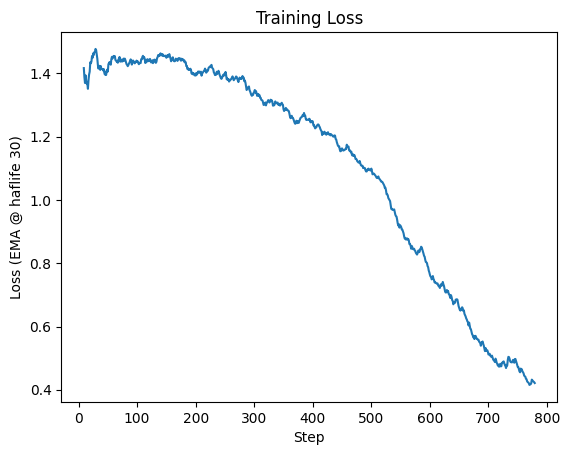

In [60]:
import pandas as pd

# Make a plot of the training of the losses
# Load presaved ones for convenience.
with open(f"{target_dir}/sft_losses.json", "r") as f:
    all_losses = json.load(f)

pd.Series(all_losses).ewm(halflife=30, min_periods=10).mean().plot()
plt.xlabel("Step")
plt.ylabel("Loss (EMA @ haflife 30)")
plt.title("Training Loss")
plt.show()


### 2.4 Evaluate SFT policy

In [61]:
## Run eval loop with fine-tuned model
sft_episodes = {"sft": []}
num_episodes_per_agent = 1

for ep in range(num_episodes_per_agent):
    printmd(f"#### Episode {ep}")
    memory, data, total_reward = episode_rollout(model_lora, gameFold="test", thinking=False)
    sft_episodes['sft'].append({"ep": ep, "total_reward": total_reward, "memory": memory, "data": data})

## save results
with open(f"{target_dir}/episodes_sft_agent.json", "w") as f:
    json.dump(sft_episodes, f)

## print an episode
printmd('\n\n'.join(sft_episodes['sft'][0]['memory']))

#### Episode 0

Episode Progress: 0it [00:00, ?it/s]

`[Task]`: Your task is to pick up objects, then place them in their usual locations in the environment.

`[Starting Obs]`: You are in the laundry room. In one part of the room you see a bench, that has nothing on it. There is also a work table, that has nothing on it. You also see a clothes drier that is closed. In another part of the room you see a laundry basket, that has nothing on it. In one part of the room you see a washing machine that is closed. There is also a razor. You also see a lip gloss. In another part of the room you see a shampoo. 
To the West you see a closed wood door. 

###  `Action step 1`

`[Time]` 21:01:25

`[Valid Actions]`: ['close door to west', 'take lip gloss', 'take shampoo', 'open washing machine', 'open door to west', 'open clothes drier', 'move west', 'inventory', 'take razor', 'look around']

`[Action]`: move west

`[Reward]`: 0.00

`[Obs]`: You can't move there, the door is closed. 

###  `Action step 2`

`[Time]` 21:01:25

`[Valid Actions]`: ['take razor', 'take lip gloss', 'inventory', 'open door to west', 'open washing machine', 'take shampoo', 'look around', 'move west', 'open clothes drier', 'close door to west']

`[Action]`: take razor

`[Reward]`: 0.12

`[Obs]`: You take the razor.

###  `Action step 3`

`[Time]` 21:01:25

`[Valid Actions]`: ['put razor in bench', 'put razor in laundry basket', 'take lip gloss', 'open washing machine', 'take shampoo', 'move west', 'close door to west', 'inventory', 'look around', 'open door to west', 'put razor in work table', 'open clothes drier']

`[Action]`: take lip gloss

`[Reward]`: 0.12

`[Obs]`: You take the lip gloss.

###  `Action step 4`

`[Time]` 21:01:25

`[Valid Actions]`: ['look around', 'put lip gloss in work table', 'put razor in work table', 'close door to west', 'open washing machine', 'put razor in bench', 'open door to west', 'move west', 'put lip gloss in bench', 'take shampoo', 'inventory', 'open clothes drier', 'put razor in laundry basket', 'put lip gloss in laundry basket']

`[Action]`: take shampoo

`[Reward]`: 0.12

`[Obs]`: You take the shampoo.

###  `Action step 5`

`[Time]` 21:01:26

`[Valid Actions]`: ['put shampoo in work table', 'look around', 'close door to west', 'open door to west', 'inventory', 'put razor in laundry basket', 'put shampoo in laundry basket', 'put razor in work table', 'put shampoo in bench', 'put lip gloss in laundry basket', 'move west', 'put lip gloss in bench', 'put lip gloss in work table', 'open washing machine', 'open clothes drier', 'put razor in bench']

`[Action]`: move west

`[Reward]`: 0.00

`[Obs]`: You can't move there, the door is closed. 

###  `Action step 6`

`[Time]` 21:01:26

`[Valid Actions]`: ['put razor in bench', 'put lip gloss in work table', 'open clothes drier', 'put lip gloss in laundry basket', 'put lip gloss in bench', 'move west', 'open washing machine', 'look around', 'put shampoo in work table', 'put shampoo in laundry basket', 'put shampoo in bench', 'close door to west', 'inventory', 'put razor in laundry basket', 'open door to west', 'put razor in work table']

`[Action]`: open washing machine

`[Reward]`: 0.00

`[Obs]`: You open the washing machine. It's empty inside.

###  `Action step 7`

`[Time]` 21:01:26

`[Valid Actions]`: ['put razor in laundry basket', 'put shampoo in work table', 'put shampoo in washing machine', 'inventory', 'put razor in bench', 'put razor in work table', 'put lip gloss in work table', 'put shampoo in laundry basket', 'look around', 'put shampoo in bench', 'open door to west', 'close door to west', 'open clothes drier', 'put razor in washing machine', 'move west', 'put lip gloss in laundry basket', 'put lip gloss in washing machine', 'put lip gloss in bench', 'close washing machine']

`[Action]`: move west

`[Reward]`: 0.00

`[Obs]`: You can't move there, the door is closed. 

###  `Action step 8`

`[Time]` 21:01:26

`[Valid Actions]`: ['put shampoo in washing machine', 'put lip gloss in work table', 'put lip gloss in laundry basket', 'open door to west', 'put shampoo in laundry basket', 'open clothes drier', 'put lip gloss in washing machine', 'look around', 'move west', 'put razor in washing machine', 'inventory', 'put shampoo in bench', 'put razor in laundry basket', 'put razor in bench', 'put lip gloss in bench', 'close washing machine', 'put razor in work table', 'put shampoo in work table', 'close door to west']

`[Action]`: move west

`[Reward]`: 0.00

`[Obs]`: You can't move there, the door is closed. 

###  `Action step 9`

`[Time]` 21:01:26

`[Valid Actions]`: ['put lip gloss in washing machine', 'put shampoo in washing machine', 'put razor in bench', 'put razor in work table', 'close washing machine', 'move west', 'put shampoo in bench', 'put lip gloss in work table', 'put razor in washing machine', 'put lip gloss in bench', 'open door to west', 'inventory', 'put razor in laundry basket', 'open clothes drier', 'put shampoo in laundry basket', 'look around', 'put shampoo in work table', 'put lip gloss in laundry basket', 'close door to west']

`[Action]`: move west

`[Reward]`: 0.00

`[Obs]`: You can't move there, the door is closed. 

###  `Action step 10`

`[Time]` 21:01:27

`[Valid Actions]`: ['put razor in laundry basket', 'put lip gloss in bench', 'put razor in bench', 'close washing machine', 'move west', 'put shampoo in laundry basket', 'put shampoo in washing machine', 'put lip gloss in work table', 'put razor in washing machine', 'look around', 'put razor in work table', 'put lip gloss in laundry basket', 'put shampoo in work table', 'put shampoo in bench', 'open door to west', 'open clothes drier', 'close door to west', 'put lip gloss in washing machine', 'inventory']

`[Action]`: move west

`[Reward]`: 0.00

`[Obs]`: You can't move there, the door is closed. 

###  `Action step 11`

`[Time]` 21:01:27

`[Valid Actions]`: ['put shampoo in laundry basket', 'open door to west', 'put lip gloss in work table', 'put lip gloss in bench', 'look around', 'move west', 'put razor in laundry basket', 'put razor in work table', 'put lip gloss in laundry basket', 'put razor in bench', 'put shampoo in washing machine', 'put shampoo in bench', 'close washing machine', 'put lip gloss in washing machine', 'open clothes drier', 'inventory', 'close door to west', 'put shampoo in work table', 'put razor in washing machine']

`[Action]`: move west

`[Reward]`: 0.00

`[Obs]`: You can't move there, the door is closed. 

###  `Action step 12`

`[Time]` 21:01:27

`[Valid Actions]`: ['put lip gloss in bench', 'put shampoo in bench', 'look around', 'put razor in laundry basket', 'put razor in bench', 'inventory', 'close door to west', 'put lip gloss in laundry basket', 'put lip gloss in work table', 'move west', 'put shampoo in washing machine', 'put razor in washing machine', 'put shampoo in work table', 'close washing machine', 'put razor in work table', 'open door to west', 'put lip gloss in washing machine', 'open clothes drier', 'put shampoo in laundry basket']

`[Action]`: move west

`[Reward]`: 0.00

`[Obs]`: You can't move there, the door is closed. 

###  `Action step 13`

`[Time]` 21:01:28

`[Valid Actions]`: ['put shampoo in work table', 'put lip gloss in washing machine', 'move west', 'look around', 'put razor in laundry basket', 'put lip gloss in bench', 'put shampoo in washing machine', 'put razor in bench', 'close washing machine', 'put lip gloss in laundry basket', 'put lip gloss in work table', 'put razor in work table', 'open clothes drier', 'open door to west', 'close door to west', 'put shampoo in laundry basket', 'inventory', 'put shampoo in bench', 'put razor in washing machine']

`[Action]`: move west

`[Reward]`: 0.00

`[Obs]`: You can't move there, the door is closed. 

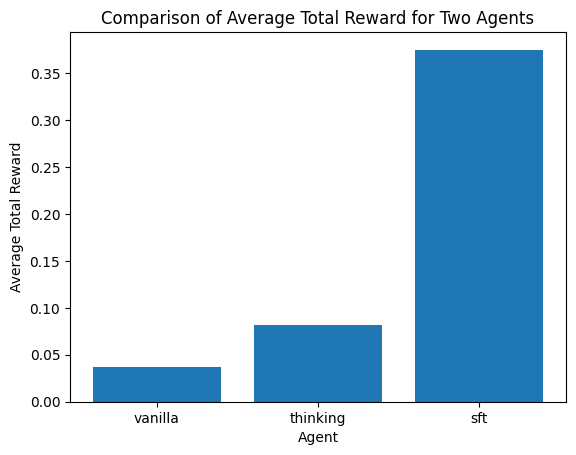

In [62]:
# import numpy as np
import matplotlib.pyplot as plt

all_eps = baseline_episodes | sft_episodes

avg_rewards = {
    a: np.mean([ep["total_reward"] for ep in all_eps[a]])
    for a in ["vanilla", "thinking", "sft"]
}

# make a bar chart
agents = list(avg_rewards.keys())
rewards = list(avg_rewards.values())

plt.bar(agents, rewards)
plt.xlabel("Agent")
plt.ylabel("Average Total Reward")
plt.title("Comparison of Average Total Reward for Two Agents")
plt.show()

# III. Reinforcement Learning


* 🥅 **Limitations of SFT** 🥅 Supervised fine-tuning refines LLMs using static datasets, there are some problems:
    * ❌ The SDR objective may be misaligned with the true objective of optimizing reward over time. This small mismatch can reduce overall peformance.
    * 🤔 In fact, SFT has been studied under the name *Behavioral Cloning* in the RL literature, showing the distribution shift between the expert and the learning agent can create several problems [(Zare et al., 2023)](https://arxiv.org/abs/2309.02473)..


 * 🐕 **Reinforcement Learning** 🐕
  * 🦾 RL addresses the limitations in SFT by enabling models to learn optimal behaviors through trial and error within interactive settings using a reward signal as feedback. In our case, we will employ RL to train LLMs using the TextWorld reward.
  * 😓 RL is very hard to train! Here we will make several simplifications to het a small feel of the approach.


* 📚 **Learning Plan**📚
  1. Let's start with an overview of RL of MDPs.
  2. Let's explain the policy gradients approach. We will use a super simplified version of proximal policy optimization [(Schulman et al. 2017)](https://arxiv.org/abs/1707.06347).
  3. We will implement a training loop and use it to further refine our SFT agent.

<!--
By integrating RL, particularly through the use of PPO, we aim to enhance the LLM's capability to learn from interactions within TextWorld, leading to improved decision-making and problem-solving skills in dynamic text-based environments. -->
<!--
<figure>
<img src="https://example.com/ppo_diagram.png" alt="PPO Algorithm Diagram" width="800"/>
<figcaption>
<b>Fig.</b> Illustration of the Proximal Policy Optimization (PPO) algorithm.<br><em>Original image</em>: <a href='https://openai.com/research/proximal-policy-optimization'>OpenAI Research on PPO</a>
</figcaption>
</figure> -->

# 3.1 🎯 A Primer on RL 🎯

RL trains an agent through **interaction** 🕹️ with an environment, aiming to **maximize cumulative rewards** 💰. Unlike supervised learning (labels) or unsupervised learning (patterns), RL relies solely on **trial-and-error feedback**.

**Key components** of an RL setup:
- **Agent** 🤖 chooses actions.
- **Environment** 🌎 provides feedback (state & reward).
- **Reward** 🏅 signals how good the action was.

The RL problem is formalized using **Markov Decision Processes (MDPs)**:
- **State** $s_t$ 📍: Current situation.
- **Action** $a_t$ 🎮: Decision taken by the agent.
- **Reward** $r_t$ 🏅: Immediate feedback from the environment.

The goal 🏆:
$$
\text{Maximize expected return } J = \mathbb{E}\left[\sum_{t=0}^{H-1} r_t\right].
$$




#### Policy Gradients

Policy gradients directly optimize the probability of choosing action $a$ in state $s$, aka, the policy $\pi_\theta(a|s)$, to maximize cumulative rewards. Instead of learning values, we adjust policy parameters $\theta$ via **gradient ascent** 📈.

The policy gradient theorem says:
$$
\nabla_{\theta} J(\theta) = \mathbb{E}\left[ \nabla_{\theta} \log \pi_{\theta}(a|s) \cdot G_t \right]
$$
where $G_t = \sum_{h=t}^{H-1} r_t$ is the **return**: the cumulative reward from the current time $t$ until the end of the episode.

In plain English 📚:
> "Increase the likelihood of actions that yield higher returns and decrease for lower returns."

**Proximal Policy Optimization (PPO)** 📌:
- PPO stabilizes training by limiting policy changes.
- Uses a clipped objective to prevent drastic policy updates:
$$
L^{\text{PPO}}(\theta) = \mathbb{E}\left[ \min(r_t(\theta)G_t, \text{clip}(r_t(\theta), 1-\epsilon, 1+\epsilon)G_t) \right]
$$

where $r_t(\theta) = \frac{\pi_{\theta}(a|s)}{\pi_{\theta_{\text{old}}}(a|s)}$.

PPO's simple mantra 🧘:
> "Improve gently, avoid radical changes."

That's it! Now we're ready to fine-tune the LLM with RL using policy gradients! 🌟

## 🚅 3.2 Training 🚅

The strategy involve two alternating steps:

1. Collect data from rollouts
2. Update the policy

We will first go through each step to illustrate the computation, and then provide the complete loop.

 ℹ️ *Technical note* ℹ️ For pedagogical reasons, the version of PPO we will implement is simplified. In particular, we will not GAE return estiation. We will also note use a KL reward with respect to a reference policy, which is commonly used for in RL training for LLMs, for instance, for RLHF.

#### The data collection step

🍀 The good news is that we already have a data collection / rollout routine. We don't need to change it. Al weed to do is compute the **remaining return**. To do this, we will **backtrack** at the end of each episode. We show this before.

In [ ]:
ep = episode_rollout(model_lora, gameFold="test", thinking=False)

# Conclusion

### 🤗 What did we learn? 🤔

* 🪜 In an agentic framework, a problem is solved step by step.
* 🆘 LLMs are trained for text completion only. Hence, they struggle at simple operations such as counting or arithmetic which are not aligned with the next-token prediction training.
* 🙇‍♂️ They can immediately solve more complex task by *thinking step by step*. We can implement it with the chain-of-thought prompting technique.
* 🛠️ By leveraging their ability to call tools (code or JSON), we can fill the gap in their abilities. We can implement it with a simple react loop, which underlies most agentic frameworks.

<br>
<img src="https://drive.google.com/uc?export=view&id=1BCv4CkAcwl07yUBEmXcZANmUASPlyyYl" alt="drawing" width="600"/>


In [ ]:
e